# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [3]:
import numpy as np
import os
import cv2 
import datetime
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(42)
import random as rn
rn.seed(42)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(42)

In this block, you read the folder names for training and validation. 

In [5]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
train_path = 'Project_data/train'
val_path = 'Project_data/val'

we will resize 360 by 360 to 120 by 120 and crop 120 by 160 (remove 20 px from left n 20 from right) -> 120 by 120

In [6]:
#data resizing - Resizing all the images to (120, 120)
def crop_resize_img(image):
    if image.shape[0]!=image.shape[1]:
        return image[:,20:140]
    return cv2.resize(image, (120, 120)) 

In [7]:
def normalize_image(img):
    normalized_image= cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return normalized_image

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
def generator(source_path, folder_list, batch_size, img_idx, img_width, img_height):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    x=len(img_idx) # no of images taken from a folder
    y=img_height
    z=img_width
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, x,y,z, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_image=crop_resize_img(image)
                    
                    batch_data[folder,idx,:,:,0] = normalize_image(resized_image[:, : , 0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = normalize_image(resized_image[:, : , 1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = normalize_image(resized_image[:, : , 2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        remaining_folder=len(folder_list)%batch_size
        if remaining_folder ==0:
            continue
        batch_data = np.zeros((remaining_folder,x,y,z, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((remaining_folder,5)) # batch_labels is the one hot representation of the output
        for folder in range(remaining_folder): # iterate over the batch_size
            imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes
                resized_image=crop_resize_img(image)

                batch_data[folder,idx,:,:,0] = normalize_image(resized_image[:, : , 0])#normalise and feed in the image
                batch_data[folder,idx,:,:,1] = normalize_image(resized_image[:, : , 1])#normalise and feed in the image
                batch_data[folder,idx,:,:,2] = normalize_image(resized_image[:, : , 2])#normalise and feed in the image
            batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

        yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
# method to plot model loss and accuracy
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [10]:
# method to train a model
def train_model(model, train_path, train_doc, val_path, val_doc, batch_size, img_idx, img_width, img_height, num_epochs, save_model=False):
    train_generator = generator(train_path, train_doc, batch_size, img_idx, img_width, img_height)
    val_generator = generator(val_path, val_doc, batch_size, img_idx, img_width, img_height)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3)

    if save_model:
        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        callbacks_list = [checkpoint, LR]

    else:
        callbacks_list = [LR]

    num_train_sequences = len(train_doc)
    print('# training sequences =', num_train_sequences)
    num_val_sequences = len(val_doc)
    print('# validation sequences =', num_val_sequences)
    print ('# epochs =', num_epochs)

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

    return history

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,LSTM
from keras.layers.convolutional import Conv3D,Conv2D, MaxPooling3D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.layers.recurrent import LSTM, GRU
from keras.optimizers import Adam
import matplotlib.pyplot as plt

## CONV3D model

Let us create our first model, For image indexes, we will skip 3 images form start and end and take alternate images in between. 

In [11]:
img_idx=[x for x in range(3,28,2)]

conv3D_model1 = Sequential()
input_shape = (len(img_idx), 120, 120, 3)

# first conv layer
conv3D_model1.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same', activation='relu', input_shape=input_shape))
conv3D_model1.add(Activation('relu'))
conv3D_model1.add(BatchNormalization())
conv3D_model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

conv3D_model1.add(Conv3D(32, (3, 3, 3), padding='same'))
conv3D_model1.add(Activation('relu'))
conv3D_model1.add(BatchNormalization())
conv3D_model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

conv3D_model1.add(Conv3D(64, (3, 3, 3), padding='same'))
conv3D_model1.add(Activation('relu'))
conv3D_model1.add(BatchNormalization())
conv3D_model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

conv3D_model1.add(Flatten())
conv3D_model1.add(Dense(64,activation='relu'))
conv3D_model1.add(BatchNormalization())

conv3D_model1.add(Dense(64,activation='relu'))
conv3D_model1.add(BatchNormalization())

conv3D_model1.add(Dense(5,activation='softmax'))

optimiser = optimizers.Adam(lr=0.001)
conv3D_model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
conv3D_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 13, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 13, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 6, 60, 60, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 6, 60, 60, 32)     13856     
_________________________________________________________________
activation_2 (Activation)    (None, 6, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 6, 60, 60, 32)     128       
__________

# training sequences = 663
# validation sequences = 100
# epochs = 50
Source path =  Project_data/val ; batch size = 100
Source path =  Project_data/train ; batch size = 100
Epoch 1/50
7/7 [==============================] - 28s 4s/step - loss: 1.3911 - categorical_accuracy: 0.4861 - val_loss: 2.9056 - val_categorical_accuracy: 0.3400

Epoch 00001: saving model to model_init_2020-12-2812_48_47.781130/model-00001-1.41257-0.47662-2.90565-0.34000.h5
Epoch 2/50
7/7 [==============================] - 15s 2s/step - loss: 0.7122 - categorical_accuracy: 0.7488 - val_loss: 1.4621 - val_categorical_accuracy: 0.6200

Epoch 00002: saving model to model_init_2020-12-2812_48_47.781130/model-00002-0.71007-0.74811-1.46214-0.62000.h5
Epoch 3/50
7/7 [==============================] - 18s 3s/step - loss: 0.4569 - categorical_accuracy: 0.8473 - val_loss: 1.0478 - val_categorical_accuracy: 0.6400

Epoch 00003: saving model to model_init_2020-12-2812_48_47.781130/model-00003-0.45105-0.85219-1.04780-0.64000.h

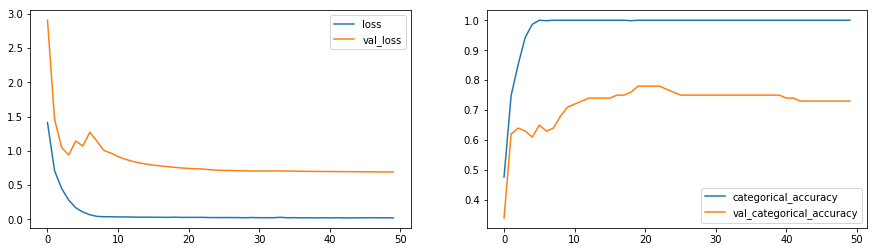

In [12]:
batch_size = 100
num_epochs = 50

model_conv3D_hist1 = train_model(conv3D_model1, train_path, train_doc, val_path, val_doc, batch_size, 
                                img_idx, 120, 120, num_epochs, save_model=True)

plot(model_conv3D_hist1)

The above model is overfitting. We will add dropout layers to reduce overfitting

In [13]:
img_idx=[x for x in range(3,28,2)]

conv3D_model2 = Sequential()
input_shape = (len(img_idx), 120, 120, 3)

# first conv layer
conv3D_model2.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same', activation='relu', input_shape=input_shape))
conv3D_model2.add(Activation('relu'))
conv3D_model2.add(BatchNormalization())
conv3D_model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

conv3D_model2.add(Conv3D(32, (3, 3, 3), padding='same'))
conv3D_model2.add(Activation('relu'))
conv3D_model2.add(BatchNormalization())
conv3D_model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

conv3D_model2.add(Conv3D(64, (3, 3, 3), padding='same'))
conv3D_model2.add(Activation('relu'))
conv3D_model2.add(BatchNormalization())
conv3D_model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

conv3D_model2.add(Flatten())
conv3D_model2.add(Dense(64,activation='relu'))
conv3D_model2.add(BatchNormalization())
conv3D_model2.add(Dropout(0.5))

conv3D_model2.add(Dense(64,activation='relu'))
conv3D_model2.add(BatchNormalization())
conv3D_model2.add(Dropout(0.5))

conv3D_model2.add(Dense(5,activation='softmax'))

optimiser = optimizers.Adam(lr=0.001)
conv3D_model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
conv3D_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 13, 120, 120, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 13, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 13, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 6, 60, 60, 16)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 6, 60, 60, 32)     13856     
_________________________________________________________________
activation_5 (Activation)    (None, 6, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 6, 60, 60, 32)     128       
__________

# training sequences = 663
# validation sequences = 100
# epochs = 50
Source path =  Project_data/val ; batch size = Source path =  Project_data/train ; batch size = 100
100
Epoch 1/50
7/7 [==============================] - 22s 3s/step - loss: 1.9585 - categorical_accuracy: 0.3334 - val_loss: 3.2706 - val_categorical_accuracy: 0.3500

Epoch 00001: saving model to model_init_2020-12-2813_04_15.938119/model-00001-1.97315-0.33032-3.27055-0.35000.h5
Epoch 2/50
7/7 [==============================] - 18s 3s/step - loss: 1.4280 - categorical_accuracy: 0.4542 - val_loss: 3.4292 - val_categorical_accuracy: 0.3300

Epoch 00002: saving model to model_init_2020-12-2813_04_15.938119/model-00002-1.42035-0.45852-3.42920-0.33000.h5
Epoch 3/50
7/7 [==============================] - 19s 3s/step - loss: 1.3022 - categorical_accuracy: 0.5161 - val_loss: 2.1752 - val_categorical_accuracy: 0.4100

Epoch 00003: saving model to model_init_2020-12-2813_04_15.938119/model-00003-1.29847-0.51885-2.17525-0.41000.h

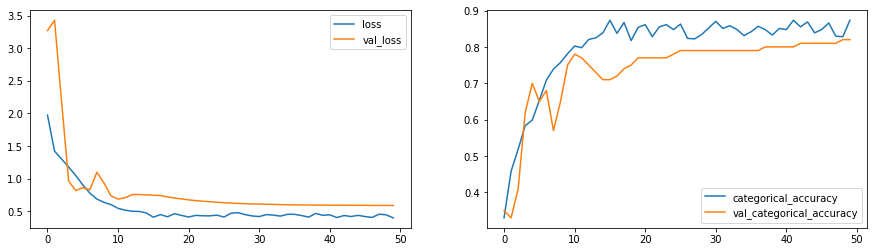

In [14]:
batch_size = 100
num_epochs = 50

model_conv3D_hist2 = train_model(conv3D_model2, train_path, train_doc, val_path, val_doc, batch_size, 
                                img_idx, 120, 120, num_epochs, save_model=True)

plot(model_conv3D_hist2)

The above model is not overfitted. And giving good validation accuracy of 82%. Let us try to add more layers and see if it can give more accuracy

In [15]:
img_idx=[x for x in range(3,28,2)]

conv3D_model3 = Sequential()
input_shape = (len(img_idx), 120, 120, 3)

# first conv layer
conv3D_model3.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same', activation='relu', input_shape=input_shape))
conv3D_model3.add(Activation('relu'))
conv3D_model3.add(BatchNormalization())
conv3D_model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

conv3D_model3.add(Conv3D(32, (3, 3, 3), padding='same'))
conv3D_model3.add(Activation('relu'))
conv3D_model3.add(BatchNormalization())
conv3D_model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

conv3D_model3.add(Conv3D(64, (3, 3, 3), padding='same'))
conv3D_model3.add(Activation('relu'))
conv3D_model3.add(BatchNormalization())
conv3D_model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

conv3D_model3.add(Conv3D(128, (3, 3, 3), padding='same'))
conv3D_model3.add(Activation('relu'))
conv3D_model3.add(BatchNormalization())
conv3D_model3.add(MaxPooling3D(pool_size=(2, 2, 2),  padding='same'))

conv3D_model3.add(Flatten())
conv3D_model3.add(Dense(64,activation='relu'))
conv3D_model3.add(BatchNormalization())
conv3D_model3.add(Dropout(0.5))

conv3D_model3.add(Dense(64,activation='relu'))
conv3D_model3.add(BatchNormalization())
conv3D_model3.add(Dropout(0.5))

conv3D_model3.add(Dense(5,activation='softmax'))

optimiser = optimizers.Adam(lr=0.001)
conv3D_model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
conv3D_model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 13, 120, 120, 16)  1312      
_________________________________________________________________
activation_7 (Activation)    (None, 13, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 13, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 6, 60, 60, 16)     0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 6, 60, 60, 32)     13856     
_________________________________________________________________
activation_8 (Activation)    (None, 6, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 6, 60, 60, 32)     128       
__________

# training sequences = 663
# validation sequences = 100
# epochs = 50
Source path =  Project_data/val Source path =  ; batch size = 100
Project_data/train ; batch size = 100
Epoch 1/50
7/7 [==============================] - 22s 3s/step - loss: 2.1205 - categorical_accuracy: 0.2787 - val_loss: 1.6371 - val_categorical_accuracy: 0.3200

Epoch 00001: saving model to model_init_2020-12-2813_19_39.741140/model-00001-2.12692-0.27602-1.63713-0.32000.h5
Epoch 2/50
7/7 [==============================] - 18s 3s/step - loss: 1.5602 - categorical_accuracy: 0.4026 - val_loss: 1.5536 - val_categorical_accuracy: 0.4300

Epoch 00002: saving model to model_init_2020-12-2813_19_39.741140/model-00002-1.56564-0.39668-1.55355-0.43000.h5
Epoch 3/50
7/7 [==============================] - 19s 3s/step - loss: 1.3359 - categorical_accuracy: 0.5069 - val_loss: 1.4723 - val_categorical_accuracy: 0.5300

Epoch 00003: saving model to model_init_2020-12-2813_19_39.741140/model-00003-1.34246-0.50377-1.47229-0.53000.h

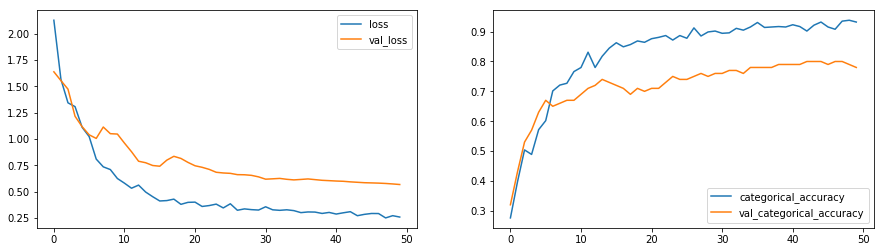

In [16]:
batch_size = 100
num_epochs = 50

model_conv3D_hist3 = train_model(conv3D_model3, train_path, train_doc, val_path, val_doc, batch_size, 
                                img_idx, 120, 120, num_epochs, save_model=True)

plot(model_conv3D_hist3)

adding more layers gives almost similar results with around 80% accuracy. Let us try changing the kernel shape on previous model and see it we get any positive change in accuracy

In [17]:
img_idx=[x for x in range(3,28,2)]

conv3D_model4 = Sequential()
input_shape = (len(img_idx), 120, 120, 3)

# first conv layer
conv3D_model4.add(Conv3D(16, kernel_size=(2, 2, 2), padding='same', activation='relu', input_shape=input_shape))
conv3D_model4.add(BatchNormalization())
conv3D_model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

# second conv layer
conv3D_model4.add(Conv3D(32, kernel_size=(2, 2, 2), padding='same', activation='relu'))
conv3D_model4.add(BatchNormalization())
conv3D_model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

# third conv layer
conv3D_model4.add(Conv3D(64, kernel_size=(2, 2, 2), padding='same', activation='relu'))
conv3D_model4.add(BatchNormalization())
conv3D_model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

conv3D_model4.add(Conv3D(128, kernel_size=(2, 2, 2), padding='same', activation='relu'))
conv3D_model4.add(BatchNormalization())
conv3D_model4.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

conv3D_model4.add(Flatten())
conv3D_model4.add(Dense(64,activation='relu'))
conv3D_model4.add(BatchNormalization())
conv3D_model4.add(Dropout(0.5))

conv3D_model4.add(Dense(64,activation='relu'))
conv3D_model4.add(BatchNormalization())
conv3D_model4.add(Dropout(0.5))

# softmax layer
conv3D_model4.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam(lr=0.001)
conv3D_model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
conv3D_model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_11 (Conv3D)           (None, 13, 120, 120, 16)  400       
_________________________________________________________________
batch_normalization_17 (Batc (None, 13, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 6, 60, 60, 16)     0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 6, 60, 60, 32)     4128      
_________________________________________________________________
batch_normalization_18 (Batc (None, 6, 60, 60, 32)     128       
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 3, 30, 30, 32)     0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 3, 30, 30, 64)     16448     
__________

# training sequences = 663
# validation sequences = 100
# epochs = 50
Source path =  Project_data/val ; batch size = 120
Source path =  Project_data/trainEpoch 1/50
 ; batch size = 120
6/6 [==============================] - 24s 4s/step - loss: 2.0934 - categorical_accuracy: 0.2993 - val_loss: 1.7199 - val_categorical_accuracy: 0.3800

Epoch 00001: saving model to model_init_2020-12-2813_34_55.875223/model-00001-2.13675-0.29563-1.71993-0.38000.h5
Epoch 2/50
6/6 [==============================] - 16s 3s/step - loss: 1.5310 - categorical_accuracy: 0.4457 - val_loss: 1.5119 - val_categorical_accuracy: 0.4200

Epoch 00002: saving model to model_init_2020-12-2813_34_55.875223/model-00002-1.53197-0.44344-1.51193-0.42000.h5
Epoch 3/50
6/6 [==============================] - 18s 3s/step - loss: 1.3140 - categorical_accuracy: 0.5091 - val_loss: 1.2082 - val_categorical_accuracy: 0.4900

Epoch 00003: saving model to model_init_2020-12-2813_34_55.875223/model-00003-1.31482-0.50226-1.20820-0.49000.h

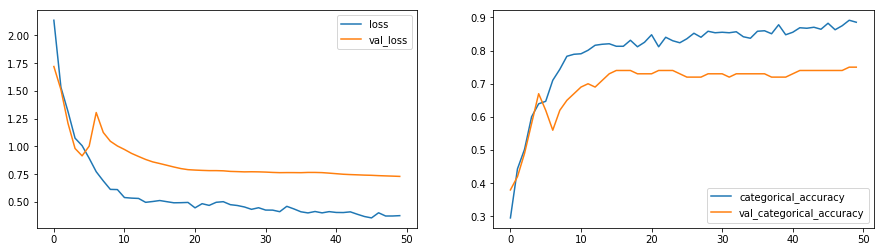

In [18]:
batch_size = 120
num_epochs = 50

model_conv3D_hist4 = train_model(conv3D_model4, train_path, train_doc, val_path, val_doc, batch_size, 
                                img_idx, 120, 120, num_epochs, save_model=True)

plot(model_conv3D_hist4)

As checked above, decresing kernal size was a bad option, we do not get a good accuracy. Let us try changing no. of neurons in dense layers of earlier model.

In [19]:
img_idx=[x for x in range(3,28,2)]

conv3D_model5 = Sequential()
input_shape = (len(img_idx), 120, 120, 3)

# first conv layer
conv3D_model5.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same', activation='relu', input_shape=input_shape))
conv3D_model5.add(Activation('relu'))
conv3D_model5.add(BatchNormalization())
conv3D_model5.add(MaxPooling3D(pool_size=(2, 2, 2)))

conv3D_model5.add(Conv3D(32, (3, 3, 3), padding='same'))
conv3D_model5.add(Activation('relu'))
conv3D_model5.add(BatchNormalization())
conv3D_model5.add(MaxPooling3D(pool_size=(2, 2, 2)))

conv3D_model5.add(Conv3D(64, (3, 3, 3), padding='same'))
conv3D_model5.add(Activation('relu'))
conv3D_model5.add(BatchNormalization())
conv3D_model5.add(MaxPooling3D(pool_size=(2, 2, 2)))

conv3D_model5.add(Conv3D(128, (3, 3, 3), padding='same'))
conv3D_model5.add(Activation('relu'))
conv3D_model5.add(BatchNormalization())
conv3D_model5.add(MaxPooling3D(pool_size=(2, 2, 2),  padding='same'))

conv3D_model5.add(Flatten())
conv3D_model5.add(Dense(128,activation='relu'))
conv3D_model5.add(BatchNormalization())
conv3D_model5.add(Dropout(0.5))

conv3D_model5.add(Dense(256,activation='relu'))
conv3D_model5.add(BatchNormalization())
conv3D_model5.add(Dropout(0.5))

conv3D_model5.add(Dense(5,activation='softmax'))

optimiser = optimizers.Adam(lr=0.001)
conv3D_model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
conv3D_model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_15 (Conv3D)           (None, 13, 120, 120, 16)  1312      
_________________________________________________________________
activation_11 (Activation)   (None, 13, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 13, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 6, 60, 60, 16)     0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 6, 60, 60, 32)     13856     
_________________________________________________________________
activation_12 (Activation)   (None, 6, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 6, 60, 60, 32)     128       
__________

# training sequences = 663
# validation sequences = 100
# epochs = 50
Source path = Source path =  Project_data/train ; batch size = 80
Epoch 1/50
 Project_data/val ; batch size = 80
9/9 [==============================] - 25s 3s/step - loss: 2.1083 - categorical_accuracy: 0.3445 - val_loss: 5.1501 - val_categorical_accuracy: 0.2800

Epoch 00001: saving model to model_init_2020-12-2813_50_00.258254/model-00001-2.10201-0.34087-5.15010-0.28000.h5
Epoch 2/50
9/9 [==============================] - 14s 2s/step - loss: 1.5276 - categorical_accuracy: 0.4803 - val_loss: 7.7737 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2020-12-2813_50_00.258254/model-00002-1.51357-0.48718-7.77370-0.25000.h5
Epoch 3/50
9/9 [==============================] - 17s 2s/step - loss: 1.3871 - categorical_accuracy: 0.5039 - val_loss: 5.8840 - val_categorical_accuracy: 0.2700

Epoch 00003: saving model to model_init_2020-12-2813_50_00.258254/model-00003-1.39172-0.49925-5.88400-0.27000.h5


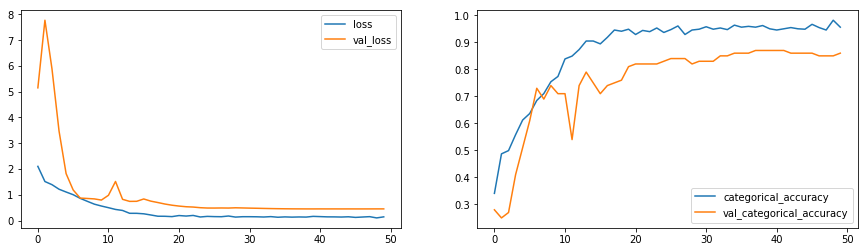

In [20]:
batch_size = 80
num_epochs = 50

model_conv3D_hist5 = train_model(conv3D_model5, train_path, train_doc, val_path, val_doc, batch_size, 
                                img_idx, 120, 120, num_epochs, save_model=True)

plot(model_conv3D_hist5)

As we can see, we are getting a good accuracy of 87%. This could be our final model, let us build some models on cnn-rnn stack

## CNN-RNN Models

Let us create our first cnn-rnn model

In [21]:
img_idx=[x for x in range(3,28,2)] # sequence of images to be taken from folder

#write your model_gru1 here
dense = [128,64]
classes = 5
# Input
input_shape=(len(img_idx),120,120,3)

model_gru1 = Sequential()

model_gru1.add(TimeDistributed(Conv2D(32, (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))

model_gru1.add(TimeDistributed(Conv2D(64, (3,3),padding='same', activation='relu')))
model_gru1.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_gru1.add(TimeDistributed(Conv2D(128, (3,3),padding='same', activation='relu')))
model_gru1.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_gru1.add(TimeDistributed(Flatten()))

model_gru1.add(Dense(dense[0], activation='relu'))

## using GRU as the RNN model_gru1 along with softmax as our last layer.
model_gru1.add(GRU(128, return_sequences=False))
model_gru1.add(Dense(classes, activation='softmax')) # using Softmax as last layer

optimiser =Adam(0.001) #write your optimizer
model_gru1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_gru1.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 13, 60, 60, 32)    896       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 13, 60, 60, 64)    18496     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 13, 30, 30, 64)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 13, 30, 30, 128)   73856     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 13, 15, 15, 128)   0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 13, 28800)         0         
_________________________________________________________________
dense_16 (Dense)             (None, 13, 128)           3686528   
__________

# training sequences = 663
# validation sequences = 100
# epochs = 50
Source path =  Project_data/val Source path =  Project_data/train ; batch size = 80
Epoch 1/50
; batch size = 80
9/9 [==============================] - 23s 3s/step - loss: 1.6279 - categorical_accuracy: 0.2180 - val_loss: 1.5998 - val_categorical_accuracy: 0.2200

Epoch 00001: saving model to model_init_2020-12-2814_05_49.616058/model-00001-1.62904-0.22474-1.59984-0.22000.h5
Epoch 2/50
9/9 [==============================] - 15s 2s/step - loss: 1.5795 - categorical_accuracy: 0.2293 - val_loss: 1.5437 - val_categorical_accuracy: 0.3200

Epoch 00002: saving model to model_init_2020-12-2814_05_49.616058/model-00002-1.58150-0.22021-1.54371-0.32000.h5
Epoch 3/50
9/9 [==============================] - 18s 2s/step - loss: 1.4507 - categorical_accuracy: 0.3773 - val_loss: 1.4169 - val_categorical_accuracy: 0.4200

Epoch 00003: saving model to model_init_2020-12-2814_05_49.616058/model-00003-1.46623-0.36953-1.41693-0.42000.h5


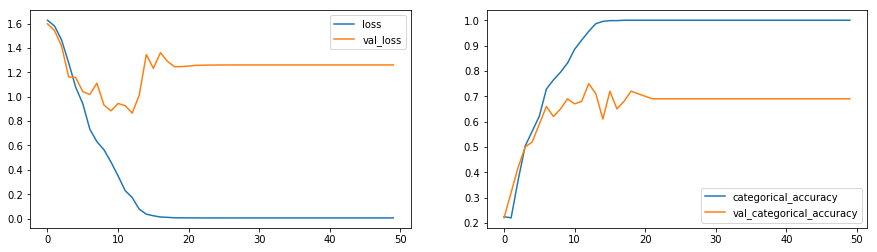

In [22]:
batch_size = 80
num_epochs = 50

model_gru1_hist=train_model(model_gru1, train_path, train_doc, val_path, val_doc, batch_size, 
                            img_idx, 120, 120, num_epochs, save_model=True)

plot(model_gru1_hist)

This model seems to be overfitting and not generalizing well, let us try adding a dense layer and decrese no. of neurons in each

In [36]:
img_idx=[x for x in range(3,28,2)] # sequence of images to be taken from folder

#write your model_gru1 here
dense = [64,64]
classes = 5
# Input
input_shape=(len(img_idx),120,120,3)

model_gru2 = Sequential()

model_gru2.add(TimeDistributed(Conv2D(32, (3, 3),activation='relu', padding='same'), input_shape=input_shape))

model_gru2.add(TimeDistributed(Conv2D(64, (3,3),padding='same', activation='relu')))
model_gru2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_gru2.add(TimeDistributed(Conv2D(128, (3,3),padding='same', activation='relu')))
model_gru2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_gru2.add(TimeDistributed(BatchNormalization()))

model_gru2.add(TimeDistributed(Flatten()))

model_gru2.add(Dense(dense[0], activation='relu'))

model_gru2.add(Dense(dense[1], activation='relu'))

## using GRU as the RNN model_gru1 along with softmax as our last layer.
model_gru2.add(GRU(128, return_sequences=False))
model_gru2.add(Dense(classes, activation='softmax')) # using Softmax as last layer

optimiser =Adam(0.001) #write your optimizer
model_gru2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_gru2.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_62 (TimeDis (None, 13, 120, 120, 32)  896       
_________________________________________________________________
time_distributed_63 (TimeDis (None, 13, 120, 120, 64)  18496     
_________________________________________________________________
time_distributed_64 (TimeDis (None, 13, 60, 60, 64)    0         
_________________________________________________________________
time_distributed_65 (TimeDis (None, 13, 60, 60, 128)   73856     
_________________________________________________________________
time_distributed_66 (TimeDis (None, 13, 30, 30, 128)   0         
_________________________________________________________________
time_distributed_67 (TimeDis (None, 13, 30, 30, 128)   512       
_________________________________________________________________
time_distributed_68 (TimeDis (None, 13, 115200)        0         
__________

# training sequences = 663
# validation sequences = 100
# epochs = 40
Source path =  Project_data/val Source path =  Project_data/train ; batch size = 60
Epoch 1/40
; batch size = 60
12/12 [==============================] - 44s 4s/step - loss: 1.6102 - categorical_accuracy: 0.3062 - val_loss: 1.4729 - val_categorical_accuracy: 0.3300

Epoch 00001: saving model to model_init_2020-12-2810_45_22.944966/model-00001-1.56678-0.33032-1.47293-0.33000.h5
Epoch 2/40
12/12 [==============================] - 28s 2s/step - loss: 1.2600 - categorical_accuracy: 0.4592 - val_loss: 1.9365 - val_categorical_accuracy: 0.2600

Epoch 00002: saving model to model_init_2020-12-2810_45_22.944966/model-00002-1.25181-0.46908-1.93649-0.26000.h5
Epoch 3/40
12/12 [==============================] - 28s 2s/step - loss: 1.1293 - categorical_accuracy: 0.5394 - val_loss: 2.1736 - val_categorical_accuracy: 0.2600

Epoch 00003: saving model to model_init_2020-12-2810_45_22.944966/model-00003-1.16906-0.52941-2.17356-0.260

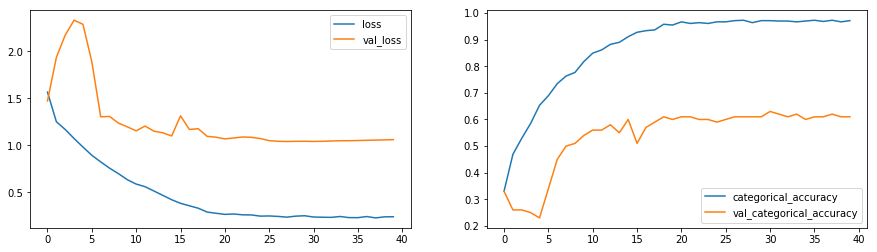

In [37]:
batch_size = 60
num_epochs = 40

model_gru2_hist=train_model(model_gru2, train_path, train_doc, val_path, val_doc, batch_size, 
                            img_idx, 120, 120, num_epochs, save_model=True)

plot(model_gru2_hist)

The model is still not able to generalize well, we need to add more feature maps, dense layers and dropout layers for increasing validation accuracy.

In [17]:
img_idx=[x for x in range(3,28,2)] # sequence of images to be taken from folder

input_shape=(len(img_idx),120,120,3)
lstm_cells = 64
dense_neurons = 64
dropout = 0.25
classes=5
model_gru3 = Sequential()

model_gru3.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
model_gru3.add(TimeDistributed(BatchNormalization()))
model_gru3.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_gru3.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_gru3.add(TimeDistributed(BatchNormalization()))
model_gru3.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_gru3.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_gru3.add(TimeDistributed(BatchNormalization()))
model_gru3.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_gru3.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_gru3.add(TimeDistributed(BatchNormalization()))
model_gru3.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_gru3.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_gru3.add(TimeDistributed(BatchNormalization()))
model_gru3.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_gru3.add(TimeDistributed(Flatten()))


model_gru3.add(GRU(lstm_cells))
model_gru3.add(Dropout(dropout))

model_gru3.add(Dense(dense_neurons,activation='relu'))
model_gru3.add(Dropout(dropout))

model_gru3.add(Dense(dense_neurons,activation='relu'))
model_gru3.add(Dropout(dropout))

model_gru3.add(Dense(classes, activation='softmax'))
optimiser = optimizers.Adam(lr=0.001)
model_gru3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model_gru3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_27 (TimeDis (None, 13, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_28 (TimeDis (None, 13, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_29 (TimeDis (None, 13, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_30 (TimeDis (None, 13, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_31 (TimeDis (None, 13, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_32 (TimeDis (None, 13, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_33 (TimeDis (None, 13, 30, 30, 64)    18496     
__________

# training sequences = 663
# validation sequences = 100
# epochs = 30
Source path =  Project_data/valSource path =  Project_data/train ; batch size = 100
 ; batch size = 100
Epoch 1/30
7/7 [==============================] - 27s 4s/step - loss: 1.6575 - categorical_accuracy: 0.2419 - val_loss: 1.4846 - val_categorical_accuracy: 0.4300

Epoch 00001: saving model to model_init_2020-12-2811_55_42.890577/model-00001-1.66301-0.23982-1.48463-0.43000.h5
Epoch 2/30
7/7 [==============================] - 14s 2s/step - loss: 1.4310 - categorical_accuracy: 0.3564 - val_loss: 1.4423 - val_categorical_accuracy: 0.4000

Epoch 00002: saving model to model_init_2020-12-2811_55_42.890577/model-00002-1.43518-0.35445-1.44225-0.40000.h5
Epoch 3/30
7/7 [==============================] - 19s 3s/step - loss: 1.3268 - categorical_accuracy: 0.4356 - val_loss: 1.3480 - val_categorical_accuracy: 0.4300

Epoch 00003: saving model to model_init_2020-12-2811_55_42.890577/model-00003-1.32602-0.43590-1.34801-0.43000.h

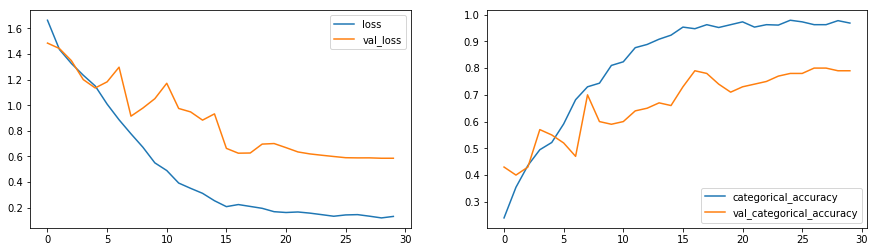

In [18]:
batch_size = 100
num_epochs = 30

model_gru3_hist=train_model(model_gru3, train_path, train_doc, val_path, val_doc, batch_size, 
                            img_idx, 120, 120, num_epochs, save_model=True)

plot(model_gru3_hist)

The above GRU model's accuracy seems to be consistent with lesser number of parameters and giving accuracy of around 80%. With the addition of drop out layer we have improved our model as it is not overfitting now.<br><br> Let us now create some LSTM based models

In [12]:
img_idx=[x for x in range(3,28,2)] # sequence of images to be taken from folder

input_shape=(len(img_idx),120,120,3)
lstm_cells = 64
dense_neurons = 64
classes=5
model_lstm1 = Sequential()

model_lstm1.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=input_shape))
model_lstm1.add(TimeDistributed(BatchNormalization()))
model_lstm1.add(TimeDistributed(MaxPooling2D((2, 2))))

model_lstm1.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_lstm1.add(TimeDistributed(BatchNormalization()))
model_lstm1.add(TimeDistributed(MaxPooling2D((2, 2))))

model_lstm1.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_lstm1.add(TimeDistributed(BatchNormalization()))
model_lstm1.add(TimeDistributed(MaxPooling2D((2, 2))))

model_lstm1.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_lstm1.add(TimeDistributed(BatchNormalization()))
model_lstm1.add(TimeDistributed(MaxPooling2D((2, 2))))

model_lstm1.add(TimeDistributed(Flatten()))

model_lstm1.add(LSTM(lstm_cells))

model_lstm1.add(Dense(dense_neurons,activation='relu'))

model_lstm1.add(Dense(dense_neurons,activation='relu'))

model_lstm1.add(Dense(classes, activation='softmax'))
optimiser = optimizers.Adam(0.005)
model_lstm1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model_lstm1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 13, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 13, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 13, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 13, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 13, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 13, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 13, 30, 30, 64)    18496     
__________

# training sequences = 663
# validation sequences = 100
# epochs = 50
Source path =  Project_data/val ; batch size = 80
Source path =  Project_data/train ; batch size = 80
Epoch 1/50
9/9 [==============================] - 24s 3s/step - loss: 1.5121 - categorical_accuracy: 0.3358 - val_loss: 1.5649 - val_categorical_accuracy: 0.2600

Epoch 00001: saving model to model_init_2020-12-2815_14_10.433778/model-00001-1.52590-0.31825-1.56492-0.26000.h5
Epoch 2/50
9/9 [==============================] - 17s 2s/step - loss: 1.2609 - categorical_accuracy: 0.4686 - val_loss: 1.3968 - val_categorical_accuracy: 0.4700

Epoch 00002: saving model to model_init_2020-12-2815_14_10.433778/model-00002-1.26924-0.46456-1.39683-0.47000.h5
Epoch 3/50
9/9 [==============================] - 18s 2s/step - loss: 1.1807 - categorical_accuracy: 0.4773 - val_loss: 2.9674 - val_categorical_accuracy: 0.2900

Epoch 00003: saving model to model_init_2020-12-2815_14_10.433778/model-00003-1.16821-0.48718-2.96745-0.29000.h5


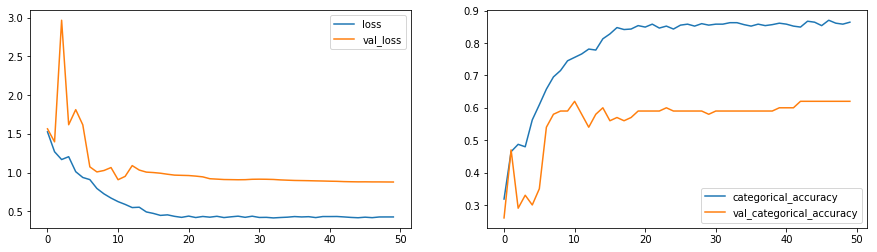

In [13]:
batch_size = 80
num_epochs = 50

model_lstm1_hist = train_model(model_lstm1, train_path, train_doc, val_path, val_doc, batch_size, 
                                   img_idx, 120, 120, num_epochs, save_model=True)

plot(model_lstm1_hist)

The above LSTM model is a case of slight overfitting, we can include drop outs to sort this out. Also we need to work on more number of parameters.

In [14]:
img_idx=[x for x in range(3,28,2)] # sequence of images to be taken from folder

input_shape=(len(img_idx),120,120,3)
lstm_cells = 128
dense_neurons = 128
dropout = 0.5
classes=5
model_lstm2 = Sequential()

model_lstm2.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=input_shape))
model_lstm2.add(TimeDistributed(BatchNormalization()))
model_lstm2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_lstm2.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_lstm2.add(TimeDistributed(BatchNormalization()))
model_lstm2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_lstm2.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_lstm2.add(TimeDistributed(BatchNormalization()))
model_lstm2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_lstm2.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_lstm2.add(TimeDistributed(BatchNormalization()))
model_lstm2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_lstm2.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_lstm2.add(TimeDistributed(BatchNormalization()))
model_lstm2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_lstm2.add(TimeDistributed(Flatten()))


model_lstm2.add(LSTM(lstm_cells))
model_lstm2.add(Dropout(dropout))

model_lstm2.add(Dense(dense_neurons,activation='relu'))
model_lstm2.add(Dropout(dropout))

model_lstm2.add(Dense(classes, activation='softmax'))
optimiser = optimizers.Adam(0.001)
model_lstm2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model_lstm2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 13, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_15 (TimeDis (None, 13, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_16 (TimeDis (None, 13, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 13, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_18 (TimeDis (None, 13, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_19 (TimeDis (None, 13, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 13, 30, 30, 64)    18496     
__________

# training sequences = 663
# validation sequences = 100
# epochs = 50
Source path = Source path =  Project_data/train ; batch size = 80
 Epoch 1/50
Project_data/val ; batch size = 80
9/9 [==============================] - 22s 2s/step - loss: 1.6210 - categorical_accuracy: 0.2708 - val_loss: 1.4965 - val_categorical_accuracy: 0.3300

Epoch 00001: saving model to model_init_2020-12-2815_29_16.339573/model-00001-1.64306-0.25490-1.49649-0.33000.h5
Epoch 2/50
9/9 [==============================] - 16s 2s/step - loss: 1.4702 - categorical_accuracy: 0.3829 - val_loss: 1.3597 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to model_init_2020-12-2815_29_16.339573/model-00002-1.48571-0.37557-1.35967-0.50000.h5
Epoch 3/50
9/9 [==============================] - 18s 2s/step - loss: 1.3563 - categorical_accuracy: 0.4291 - val_loss: 1.2897 - val_categorical_accuracy: 0.5200

Epoch 00003: saving model to model_init_2020-12-2815_29_16.339573/model-00003-1.34697-0.42534-1.28970-0.52000.h5


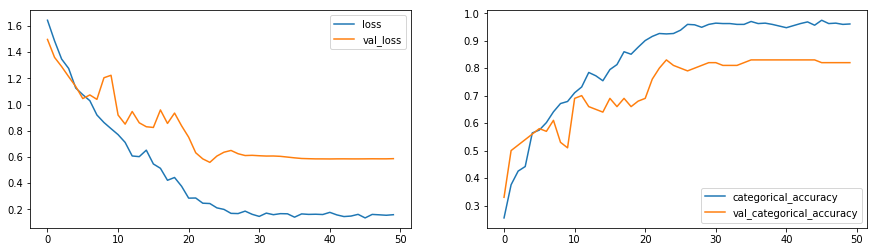

In [15]:
batch_size = 80
num_epochs = 50

model_lstm2_hist = train_model(model_lstm2, train_path, train_doc, val_path, val_doc, batch_size, 
                                   img_idx, 120, 120, num_epochs, save_model=True)

plot(model_lstm2_hist)

The above model gives good results and overfitting is handled with fewer number of parameters with accuracy of around 82%.